# Finding the Best Recession Predictors with MDA

Time for the main event! We'll use Multiple Discriminant Analysis to figure out which economic indicators are the best at spotting recessions before they hit. Think of it as teaching our model to recognize the warning signs.

In [1]:
# Import notebook utilities
from notebook_utils import (
    # Setup functions
    setup_notebook, load_data, display_data_info, save_figure,
    
    # Import from econ_downturn package
    apply_mda, create_discriminant_time_series,
    plot_feature_importance, plot_mda_projection, plot_discriminant_time_series
)

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from sklearn.model_selection import train_test_split

# Set up the notebook environment
setup_notebook()

Notebook environment set up successfully.
Available data paths:
  fred_dir: /home/mattgroho/github/economic-downturn-detector/data/fred
  nber_dir: /home/mattgroho/github/economic-downturn-detector/data/nber
  processed_dir: /home/mattgroho/github/economic-downturn-detector/data/processed
  fred_all_indicators: /home/mattgroho/github/economic-downturn-detector/data/fred/all_indicators.csv
  nber_recession_indicator: /home/mattgroho/github/economic-downturn-detector/data/nber/recession_indicator.csv
  merged_data: /home/mattgroho/github/economic-downturn-detector/data/processed/merged_data.csv
  data_with_features: /home/mattgroho/github/economic-downturn-detector/data/processed/data_with_features.csv
  data_normalized: /home/mattgroho/github/economic-downturn-detector/data/processed/data_normalized.csv
  data_pca: /home/mattgroho/github/economic-downturn-detector/data/processed/data_pca.csv

Available output paths:
  images_dir: /home/mattgroho/github/economic-downturn-detector/docs/im

## Loading Our Engineered Features

Let's grab all those nicely processed datasets we created in the previous step.

In [2]:
# Get data paths for loading processed data
from econ_downturn import get_data_paths
data_paths = get_data_paths()
data_dir = data_paths['processed_dir']

# Load the dataset with features
features_path = os.path.join(data_dir, 'data_with_features.csv')
if os.path.exists(features_path):
    data_features = pd.read_csv(features_path, index_col=0, parse_dates=True)
    print(f"Loaded dataset with features, shape: {data_features.shape}")
else:
    print(f"Dataset with features not found at {features_path}")
    data_features = pd.DataFrame()

# Load the normalized dataset
normalized_path = os.path.join(data_dir, 'data_normalized.csv')
if os.path.exists(normalized_path):
    data_normalized = pd.read_csv(normalized_path, index_col=0, parse_dates=True)
    print(f"Loaded normalized dataset, shape: {data_normalized.shape}")
else:
    print(f"Normalized dataset not found at {normalized_path}")
    data_normalized = pd.DataFrame()

# Load the PCA dataset
pca_path = os.path.join(data_dir, 'data_pca.csv')
if os.path.exists(pca_path):
    data_pca = pd.read_csv(pca_path, index_col=0, parse_dates=True)
    print(f"Loaded PCA dataset, shape: {data_pca.shape}")
else:
    print(f"PCA dataset not found at {pca_path}")
    data_pca = pd.DataFrame()

Loaded dataset with features, shape: (635, 89)
Loaded normalized dataset, shape: (635, 89)
Loaded PCA dataset, shape: (635, 24)


## Setting Up for Analysis

Before we can run our MDA, we need to split our data into training and testing sets. This way we can see how well our model performs on data it hasn't seen before.

In [3]:
# Function to prepare data for MDA
def prepare_data_for_mda(data):
    if data.empty or 'recession' not in data.columns:
        print("Data is empty or does not contain the recession indicator.")
        return None, None
    
    # Separate features and target
    X = data.drop(columns=['recession'])
    y = data['recession']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    return (X_train, X_test, y_train, y_test), (X, y)

# Prepare the datasets for MDA
datasets = {}

if not data_features.empty and 'recession' in data_features.columns:
    datasets['features'] = prepare_data_for_mda(data_features)
    print("Prepared dataset with features for MDA")

if not data_normalized.empty and 'recession' in data_normalized.columns:
    datasets['normalized'] = prepare_data_for_mda(data_normalized)
    print("Prepared normalized dataset for MDA")

if not data_pca.empty and 'recession' in data_pca.columns:
    datasets['pca'] = prepare_data_for_mda(data_pca)
    print("Prepared PCA dataset for MDA")

Prepared dataset with features for MDA
Prepared normalized dataset for MDA


## Running the MDA Model

Here's where the magic happens! We'll train our MDA model to learn the patterns that distinguish recession periods from normal economic times.

2025-06-09 17:58:00,406 - econ_downturn.models.mda - INFO - Training set shape: (444, 88), Testing set shape: (191, 88)
2025-06-09 17:58:00,419 - econ_downturn.models.mda - INFO - Accuracy: 0.9686
2025-06-09 17:58:00,420 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[166   3]
 [  3  19]]
2025-06-09 17:58:00,421 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       169
         1.0       0.86      0.86      0.86        22

    accuracy                           0.97       191
   macro avg       0.92      0.92      0.92       191
weighted avg       0.97      0.97      0.97       191

2025-06-09 17:58:00,443 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.96062992 0.96062992 0.96850394 0.94488189 0.98425197]
2025-06-09 17:58:00,444 - econ_downturn.models.mda - INFO - Mean CV Score: 0.9638
2025-06-09 17:58:00,446 - econ_downturn.models.mda - INFO - Top 5 Mo

,Feature,Importance
73,INDUSTRIAL_PROD_pct_change_1,890.088681
57,GDP_pct_change_12,582.748444
61,CPI_pct_change_1,557.520916
75,INDUSTRIAL_PROD_pct_change_12,458.107725
56,GDP_pct_change_3,391.269370
62,CPI_pct_change_3,357.676971
63,CPI_pct_change_12,195.986278
55,GDP_pct_change_1,139.278332
74,INDUSTRIAL_PROD_pct_change_3,93.876068
78,RETAIL_SALES_pct_change_12,85.230129


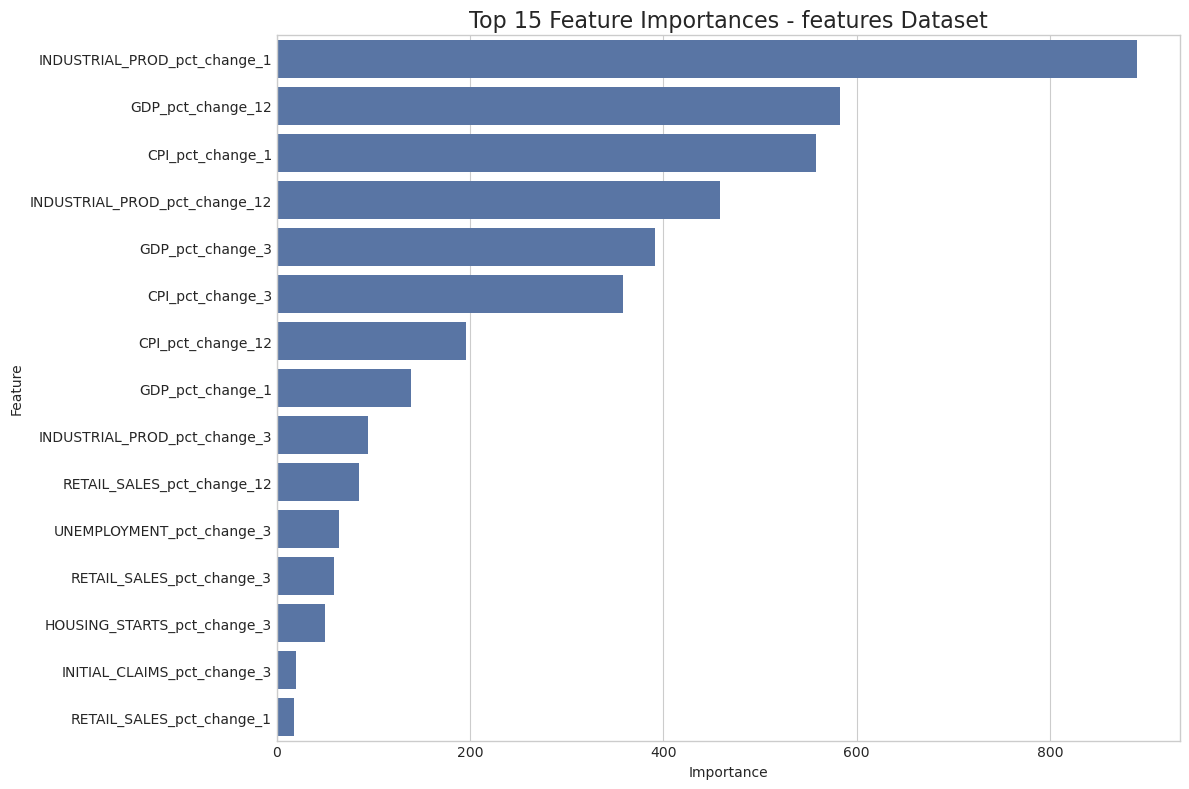

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/feature_importance_features.png
2025-06-09 17:58:00,626 - econ_downturn.models.mda - INFO - Training set shape: (444, 88), Testing set shape: (191, 88)
2025-06-09 17:58:00,634 - econ_downturn.models.mda - INFO - Accuracy: 0.9686
2025-06-09 17:58:00,635 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[166   3]
 [  3  19]]
2025-06-09 17:58:00,636 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       169
         1.0       0.86      0.86      0.86        22

    accuracy                           0.97       191
   macro avg       0.92      0.92      0.92       191
weighted avg       0.97      0.97      0.97       191

2025-06-09 17:58:00,663 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.96062992 0.96062992 0.96850394 0.94488189 0.98425197]
2025-06-09 17:58:00,665 - econ_downturn.

,Feature,Importance
2,CPI,336.406123
19,CPI_lag1,325.844448
35,INDUSTRIAL_PROD_lag1,230.760526
12,GDP_lag3,229.915634
14,GDP_lag12,216.256644
38,INDUSTRIAL_PROD_lag12,143.372394
0,GDP,116.423274
22,CPI_lag12,107.839097
20,CPI_lag3,103.901940
11,GDP_lag1,97.882237


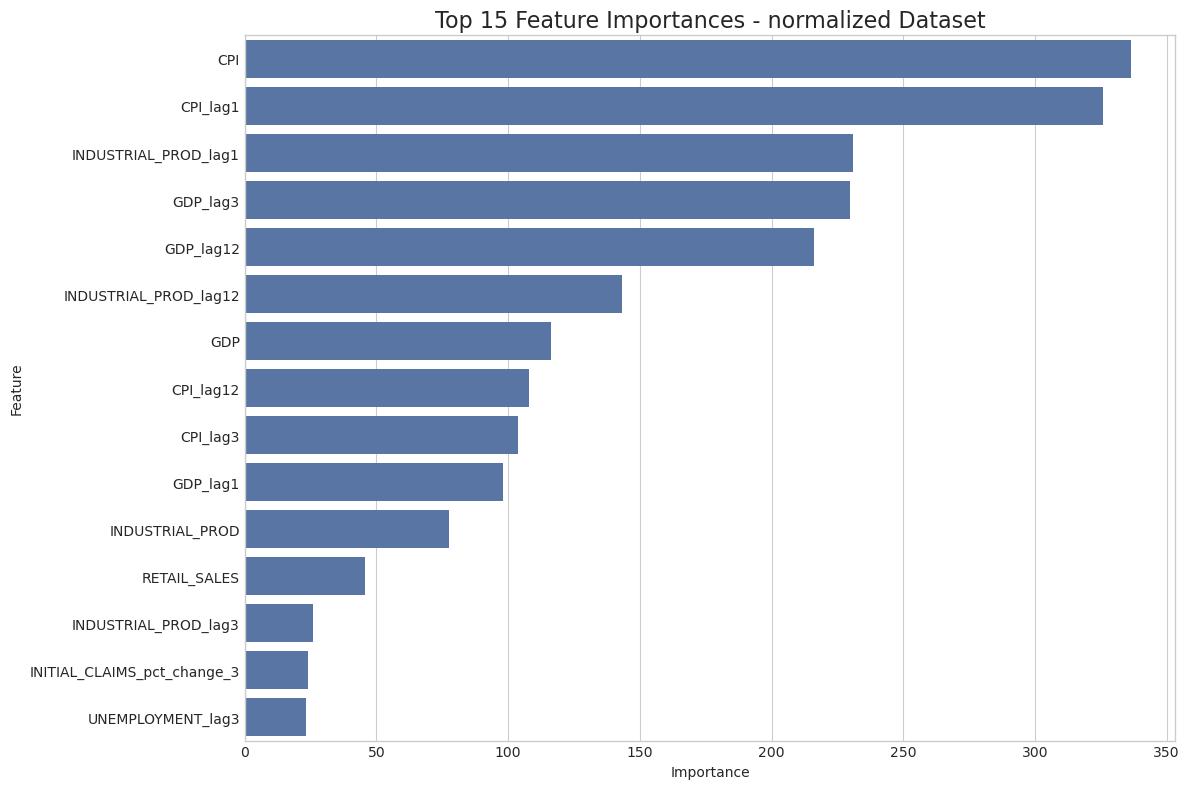

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/feature_importance_normalized.png


In [4]:
# Function to apply MDA and evaluate the model
def apply_mda_and_evaluate(dataset_name, split_data, full_data):
    if split_data is None or full_data is None:
        print(f"No data available for {dataset_name}")
        return None
    
    X_train, X_test, y_train, y_test = split_data
    X_full, y_full = full_data
    
    # Apply MDA using the package function (it handles train/test split internally)
    mda_results = apply_mda(X_full, y_full, test_size=0.3, random_state=42)
    
    print(f"\nResults for {dataset_name} dataset:")
    print(f"Accuracy: {mda_results['accuracy']:.4f}")
    print("\nConfusion Matrix:")
    print(mda_results['conf_matrix'])
    print("\nClassification Report:")
    print(mda_results['class_report'])
    print(f"\nCross-Validation Scores: {mda_results['cv_scores']}")
    print(f"Mean CV Score: {mda_results['cv_scores'].mean():.4f}")
    
    # Plot feature importances
    if mda_results['feature_importance'] is not None:
        print("\nTop 10 Most Important Features:")
        display(mda_results['feature_importance'].head(10))
        
        # Plot feature importances
        fig = plot_feature_importance(mda_results['feature_importance'], top_n=15)
        plt.title(f'Top 15 Feature Importances - {dataset_name} Dataset', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Save the figure
        save_figure(fig, f"feature_importance_{dataset_name}.png")
    
    return mda_results

# Apply MDA to each dataset
mda_results = {}

for name, (split_data, full_data) in datasets.items():
    mda_results[name] = apply_mda_and_evaluate(name, split_data, full_data)

## Visualizing Our Results

Let's create some charts to see how well our model separates recession periods from normal times. Visual patterns often tell us more than numbers alone.

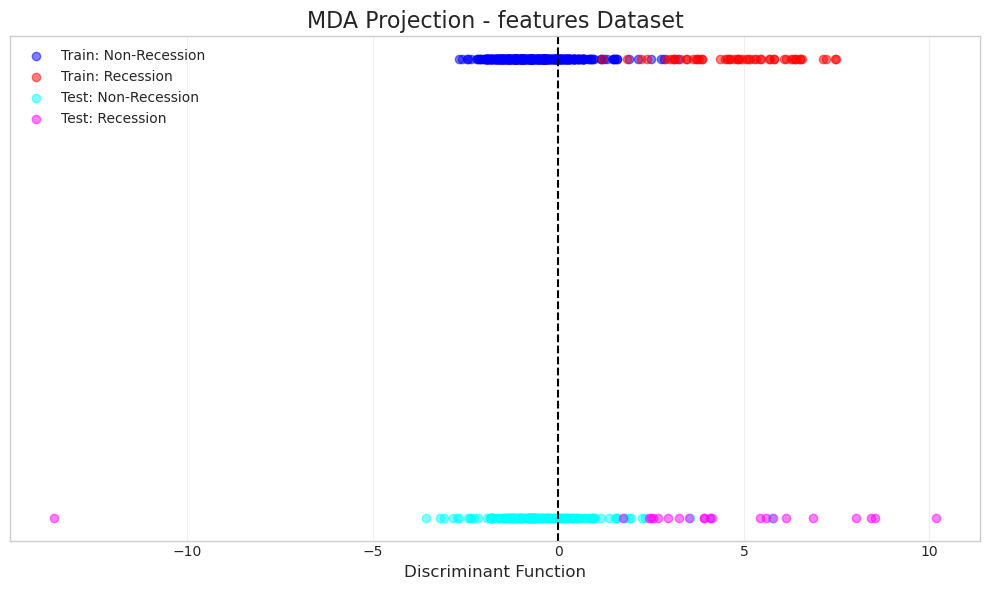

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/mda_projection_features.png


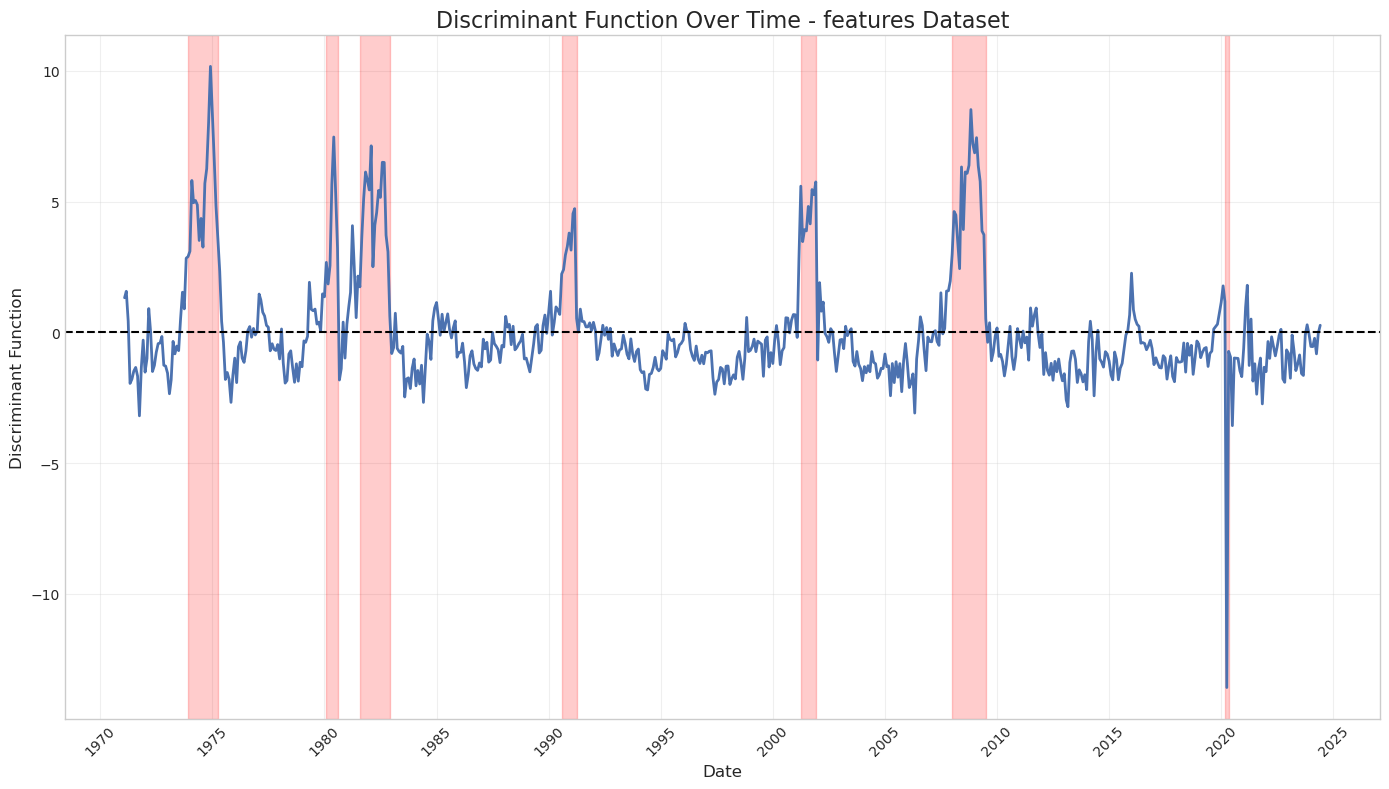

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/discriminant_time_series_features.png


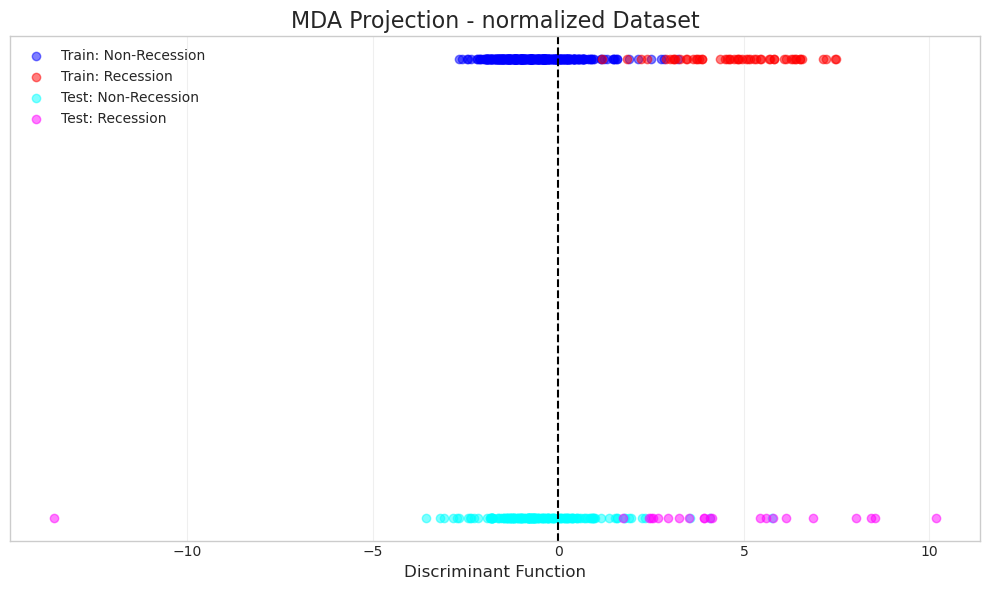

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/mda_projection_normalized.png


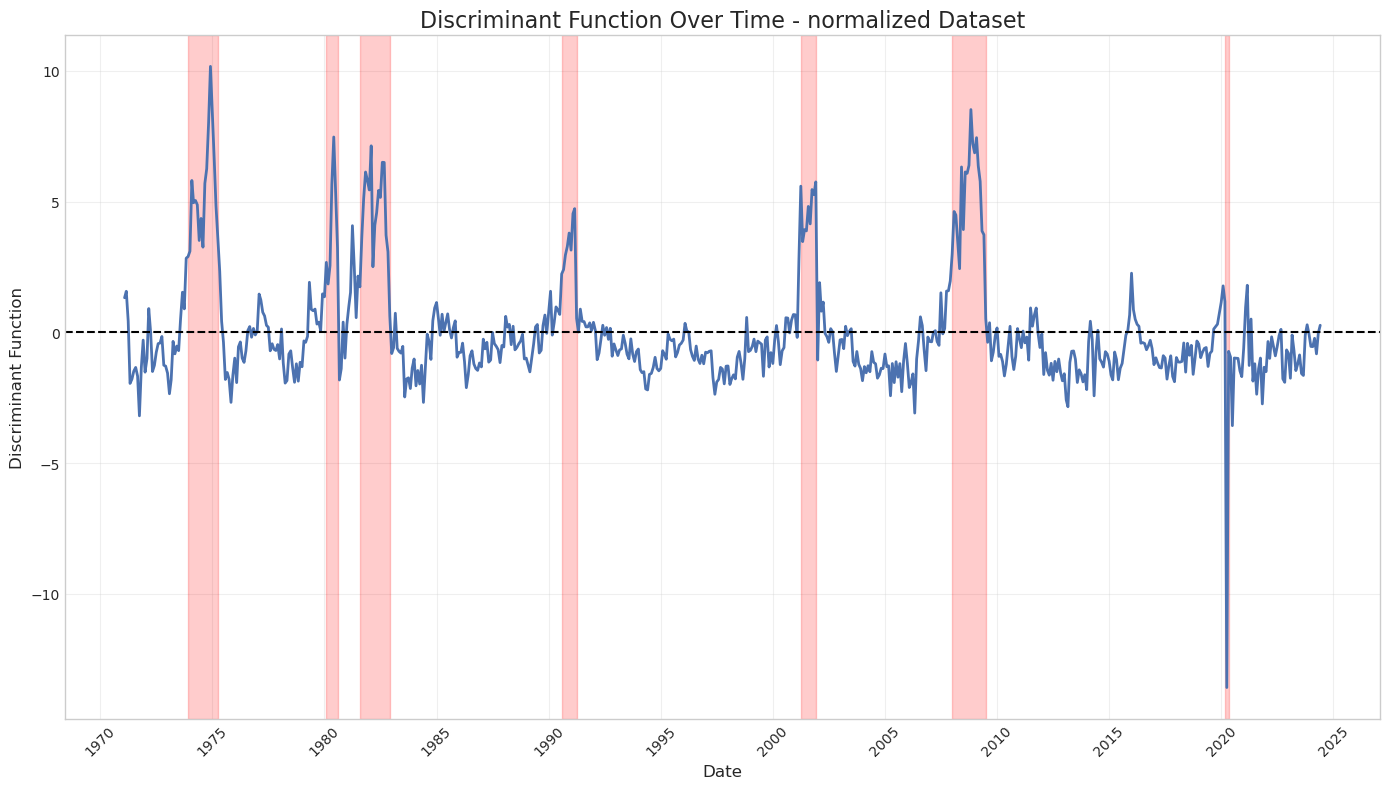

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/discriminant_time_series_normalized.png


In [5]:
# Function to visualize MDA results
def visualize_mda_results(dataset_name, mda_results, split_data, full_data):
    if mda_results is None or split_data is None or full_data is None:
        print(f"No data available for {dataset_name}")
        return
    
    X_train, X_test, y_train, y_test = split_data
    X_full, y_full = full_data
    
    # Plot MDA projection (function extracts data from mda_results internally)
    fig = plot_mda_projection(mda_results)
    plt.title(f'MDA Projection - {dataset_name} Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    save_figure(fig, f"mda_projection_{dataset_name}.png")
    
    # Create discriminant time series
    discriminant_df = create_discriminant_time_series(mda_results['model'], X_full, y_full)
    
    # Plot discriminant time series
    fig = plot_discriminant_time_series(discriminant_df)
    plt.title(f'Discriminant Function Over Time - {dataset_name} Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    save_figure(fig, f"discriminant_time_series_{dataset_name}.png")

# Visualize MDA results for each dataset
for name, results in mda_results.items():
    if results is not None:
        visualize_mda_results(name, results, datasets[name][0], datasets[name][1])

## Which Indicators Matter Most?

Now for the big reveal - which economic indicators are actually the best at predicting recessions? Let's rank them by importance and see what patterns emerge.

In [6]:
# Function to identify key recession predictors
def identify_key_predictors(dataset_name, mda_results):
    if mda_results is None or mda_results['feature_importance'] is None:
        print(f"No feature importance available for {dataset_name}")
        return
    
    feature_importance = mda_results['feature_importance']
    
    print(f"\nKey Recession Predictors from {dataset_name} Dataset:")
    
    # Get the top 10 features
    top_features = feature_importance.head(10)
    display(top_features)
    
    # Categorize the features
    categories = {
        'Original': [],
        'Lag': [],
        'Rate of Change': []
    }
    
    for feature in top_features['Feature']:
        if '_lag' in feature:
            categories['Lag'].append(feature)
        elif '_pct_change' in feature or '_roc' in feature:
            categories['Rate of Change'].append(feature)
        else:
            categories['Original'].append(feature)
    
    print("\nFeatures by Category:")
    for category, features in categories.items():
        print(f"\n{category} Features:")
        for feature in features:
            print(f"- {feature}")

# Identify key predictors for each dataset
for name, results in mda_results.items():
    if results is not None:
        identify_key_predictors(name, results)


Key Recession Predictors from features Dataset:


,Feature,Importance
73,INDUSTRIAL_PROD_pct_change_1,890.088681
57,GDP_pct_change_12,582.748444
61,CPI_pct_change_1,557.520916
75,INDUSTRIAL_PROD_pct_change_12,458.107725
56,GDP_pct_change_3,391.269370
62,CPI_pct_change_3,357.676971
63,CPI_pct_change_12,195.986278
55,GDP_pct_change_1,139.278332
74,INDUSTRIAL_PROD_pct_change_3,93.876068
78,RETAIL_SALES_pct_change_12,85.230129



Features by Category:

Original Features:

Lag Features:

Rate of Change Features:
- INDUSTRIAL_PROD_pct_change_1
- GDP_pct_change_12
- CPI_pct_change_1
- INDUSTRIAL_PROD_pct_change_12
- GDP_pct_change_3
- CPI_pct_change_3
- CPI_pct_change_12
- GDP_pct_change_1
- INDUSTRIAL_PROD_pct_change_3
- RETAIL_SALES_pct_change_12

Key Recession Predictors from normalized Dataset:


,Feature,Importance
2,CPI,336.406123
19,CPI_lag1,325.844448
35,INDUSTRIAL_PROD_lag1,230.760526
12,GDP_lag3,229.915634
14,GDP_lag12,216.256644
38,INDUSTRIAL_PROD_lag12,143.372394
0,GDP,116.423274
22,CPI_lag12,107.839097
20,CPI_lag3,103.901940
11,GDP_lag1,97.882237



Features by Category:

Original Features:
- CPI
- GDP

Lag Features:
- CPI_lag1
- INDUSTRIAL_PROD_lag1
- GDP_lag3
- GDP_lag12
- INDUSTRIAL_PROD_lag12
- CPI_lag12
- CPI_lag3
- GDP_lag1

Rate of Change Features:
